In [3]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.33.2
    Uninstalling grpcio-1.33.2:
      Successfully uninstalled grpcio-1.33.2
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.1
    Uninstalling tensorflow-2.3.1:
      Successfully uninstalled tensorflow-2.3.1


ERROR: apache-beam 2.26.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.
ERROR: apache-beam 2.26.0 has requirement mock<3.0.0,>=1.0.1, but you'll have mock 4.0.3 which is incompatible.


In [4]:
!pip install pycocotools

In [1]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [2]:
%%cmd  #veya %%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

Microsoft Windows [Version 10.0.19041.685]
(c) 2020 Microsoft Corporation. Tüm hakları saklıdır.

(base) C:\Users\burak\SheepObjectDetect>cd models/research/

(base) C:\Users\burak\SheepObjectDetect\models\research>protoc object_detection/protos/*.proto --python_out=.

(base) C:\Users\burak\SheepObjectDetect\models\research>

In [8]:
%%cmd 
cd models/research
pip install .

Microsoft Windows [Version 10.0.19041.685]
(c) 2020 Microsoft Corporation. T�m haklar� sakl�d�r.

(base) D:\>cd models/research

(base) D:\models\research>pip install .
Processing d:\models\research
  Using cached mock-2.0.0-py2.py3-none-any.whl (56 kB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1609656 sha256=d6c0dca57c30c6d572527362d38eb92bd07a24819e90121bc573fb96bdb06824
  Stored in directory: C:\Users\burak\AppData\Local\Temp\pip-ephem-wheel-cache-j3h28mm7\wheels\68\0e\82\cd7e9bde97df3e818f1578ab06928756938274234bd620ab43
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1
  Attempting uninstall: mock
    Found existing installation: mock 4.0.3
    Uninstalling mock-4.0.3:
      Successfully uninstalled mock-4.0.3

(base) D:\models\research>

ERROR: apache-beam 2.26.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [4]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [5]:
utils_ops.tf = tf.compat.v1

tf.gfile = tf.io.gfile

In [6]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

In [7]:
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [10]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('C:/Users/burak/SheepObjectDetect/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('C:/Users/burak/SheepObjectDetect/test_images/1.jpg'),
 WindowsPath('C:/Users/burak/SheepObjectDetect/test_images/2.jpg'),
 WindowsPath('C:/Users/burak/SheepObjectDetect/test_images/3.jpg')]

In [11]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]

  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  if 'detection_masks' in output_dict:
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [13]:
def show_inference(model, image_path):
  image_np = np.array(Image.open(image_path))
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

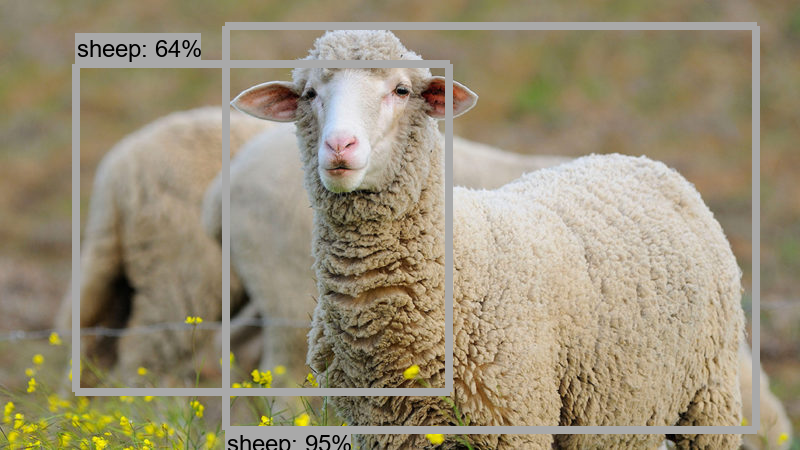

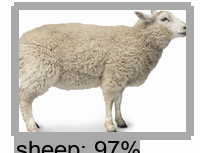

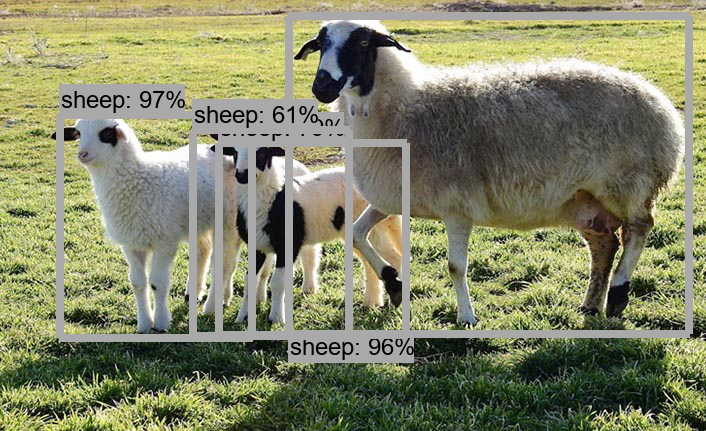

In [14]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)
